In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import ast
import shutil
from skimage import io, draw
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as albu
from albumentations import Compose
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!7z e '/content/drive/MyDrive/Project/detectron/real_Image_dataset_Detection.tar.7z'
!mkdir detection
!tar -xvf '/content/real_Image_dataset_Detection.tar' -C '/content/detection'

In [ ]:
import torch
from IPython.core.display import clear_output

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
os.chdir('/content/yolov5')
%pip install -qr requirements.txt --use-deprecated=legacy-resolver
os.chdir('/content')
!pwd

Cloning into 'yolov5'...
remote: Enumerating objects: 15291, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 15291 (delta 0), reused 1 (delta 0), pack-reused 15287
Receiving objects: 100% (15291/15291), 14.19 MiB | 15.53 MiB/s, done.
Resolving deltas: 100% (10489/10489), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.7 MB/s eta 0:00:00
ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you'll have setuptools 67.6.0 which is incompatible.
/content


In [ ]:
image_folder = '/content/detection/real_Image_dataset_Detection/Image'
image_path = [os.path.join(image_folder, name) for name in os.listdir(image_folder)]
annotation_path = '/content/detection/real_Image_dataset_Detection/Annotation'
annotations = pd.DataFrame(columns = ['img_path','img_height','img_width','box','coordinates','height','width','xy_center','language'])

data = {}

Function to allign all corner coordinates such that rectangular bounding box will be produced

In [ ]:
def correct_coordinates(coord):
    x1,x2,x3,x4,y1,y2,y3,y4 = coord[0],coord[1],coord[2],coord[3],coord[4],coord[5],coord[6],coord[7]
    x1 = x4 = min(x1,x4)
    x2 = x3 = max(x2,x3)
    y1 = y2 = min(y1,y2)
    y3 = y4 = max(y3,y4)
    return(x1,x2,x3,x4,y1,y2,y3,y4)


Function to calculate bounding box features

In [ ]:
def box_features(file_path):
    with open(file_path,'r') as annot:
        box = []
        for num in annot.readlines():
            temp = {}
            coord = num.split(',')[:8]
            coord = correct_coordinates([int(i) for i in coord])
            temp['coord'] = coord
            temp['height'] = abs(coord[7] - coord[4])
            temp['width'] = abs(coord[1] - coord[0])
            temp['box'] = (coord[0],coord[4],coord[2],coord[6])
            temp['xy_center'] = [(coord[0] + coord[1]) / 2, (coord[4] + coord[7]) / 2]
            language = num.split(',')[-1].split('::')[-1].rstrip('\n')
            if language == "ENGLISH":
                continue
            temp['language'] = language
            box.append(temp)
    return box

In [ ]:

for path in tqdm(image_path):
    data['img_path'] = path
    img_name = os.path.splitext(os.path.basename(path))[0]
    annot_path = os.path.join(annotation_path,f"{img_name}.txt")
    box = box_features(annot_path)
    if len(box) == 0:
        continue

    data['coordinates'] = [i['coord'] for i in box]
    data['height'] = [i['height'] for i in box]
    data['width'] = [i['width'] for i in box]
    data['language'] = [i['language'] for i in box]
    data['box'] = [i['box'] for i in box]
    data['xy_center'] = [i['xy_center'] for i in box]
    im = cv2.imread(path)
    data['img_height'] = im.shape[0]
    data['img_width'] = im.shape[1]
    annotations = annotations.append(data, ignore_index = True)


100%|██████████| 428/428 [00:03<00:00, 113.56it/s]


In [ ]:
annotations.head()

,img_path,img_height,img_width,box,coordinates,height,width,xy_center,language
0,/content/detection/real_Image_dataset_Detectio...,500,715,"[(215, 83, 477, 203), (215, 192, 390, 265), (3...","[(215, 477, 477, 215, 83, 83, 203, 203), (215,...","[120, 73, 67, 34, 42, 40, 32, 27, 32, 35, 36, ...","[262, 175, 89, 77, 81, 74, 52, 66, 50, 25, 79,...","[[346.0, 143.0], [302.5, 228.5], [437.5, 213.5...","[HINDI, HINDI, HINDI, HINDI, HINDI, HINDI, HIN..."
1,/content/detection/real_Image_dataset_Detectio...,500,715,"[(128, 162, 714, 345), (182, 332, 483, 491), (...","[(128, 714, 714, 128, 162, 162, 345, 345), (18...","[183, 159, 132]","[586, 301, 211]","[[421.0, 253.5], [332.5, 411.5], [592.5, 431.0]]","[HINDI, HINDI, HINDI]"
2,/content/detection/real_Image_dataset_Detectio...,500,715,"[(235, 264, 450, 352), (36, 391, 238, 493), (2...","[(235, 450, 450, 235, 264, 264, 352, 352), (36...","[88, 102, 115, 115]","[215, 202, 233, 145]","[[342.5, 308.0], [137.0, 442.0], [360.5, 408.5...","[HINDI, HINDI, HINDI, HINDI]"
3,/content/detection/real_Image_dataset_Detectio...,500,715,"[(4, 247, 91, 334), (105, 249, 278, 337), (287...","[(4, 91, 91, 4, 247, 247, 334, 334), (105, 278...","[87, 88, 70, 95, 37, 28, 38, 34, 37]","[87, 173, 248, 164, 98, 113, 117, 102, 121]","[[47.5, 290.5], [191.5, 293.0], [411.0, 300.0]...","[HINDI, HINDI, HINDI, HINDI, HINDI, HINDI, HIN..."
4,/content/detection/real_Image_dataset_Detectio...,899,1199,"[(147, 172, 768, 298), (781, 193, 1076, 315), ...","[(147, 768, 768, 147, 172, 172, 298, 298), (78...","[126, 122, 112, 81]","[621, 295, 147, 255]","[[457.5, 235.0], [928.5, 254.0], [282.5, 510.0...","[HINDI, HINDI, HINDI, HINDI]"


In [ ]:
def plot_img(img, box):
    if isinstance(img,torch.Tensor):
        img = img.permute(1,2,0).numpy()

    for i in box:
        if isinstance(i,torch.Tensor):
            i = i.numpy()
        start = tuple(i[:2])
        end = tuple(i[2:])

        cv2.rectangle(img,start,end,[255,0,0],3)
    return img

Lets check by plotting random image with bounding box from train dataset

/content/detection/real_Image_dataset_Detection/Image/286.jpg [(33, 332, 458, 497)]


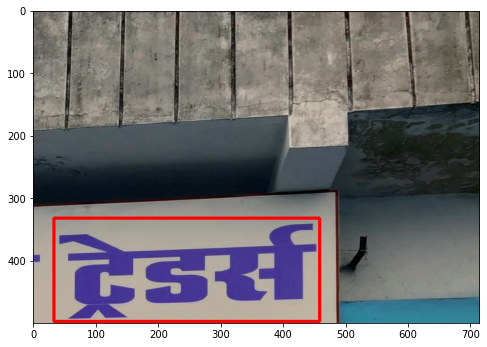

In [ ]:
plt.figure(figsize = (8,8))
i = 150 # Random image location in data
img = cv2.imread(annotations.iloc[i,0])
box = annotations.iloc[i,3]
print(annotations.iloc[i,0],box)
img = plot_img(img,box)
plt.imshow(img)
plt.show()

In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!cd /content/detection/real_Image_dataset_Detection/Annotation


In [ ]:
!pwd

/content/yolov5


Folders arrangement inside base directory
base_dir:
    # images
        # train
        # validation
    # labels
        # train
        # validation

In [ ]:
base_dir = 'base_dir'
os.mkdir(base_dir)
images = os.path.join(base_dir, 'images')
os.mkdir(images)
labels = os.path.join(base_dir, 'labels')
os.mkdir(labels)
# Inside each folder we create seperate folders for each class
train = os.path.join(images, 'train')
os.mkdir(train)
validation = os.path.join(images, 'validation')
os.mkdir(validation)
train = os.path.join(labels, 'train')
os.mkdir(train)
validation = os.path.join(labels, 'validation')
os.mkdir(validation)


In [ ]:
os.chdir('/content')
!pwd

/content


In [ ]:
# Splitting train and validation data
df_train, df_val = train_test_split(annotations, test_size=0.2, random_state=101)

print(df_train.shape)
print(df_val.shape)

(341, 9)
(86, 9)


In [ ]:
yolo_data = []

In [ ]:
def process_data_for_yolo(df, data_type='train'):
    for _, row in tqdm(df.iterrows(), total=len(df)):

            image_name = os.path.basename(row['img_path'])

            xy_center = row['xy_center']
            image_width = row['img_width']
            image_height = row['img_height']
            box_width = row['width']
            box_height = row['height']

            yolo_data = []
            for (coord,box_width,box_height) in zip(xy_center,box_width,box_height):
                class_id = 0

                x_center = coord[0]/image_width
                y_center = coord[1]/image_height
                box_width = box_width/image_width
                box_height = box_height/image_height

                yolo_list = [class_id,x_center,y_center,box_width,box_height]
                yolo_data.append(yolo_list)
                #yolo_data = np.array(yolo_data)

                image_id = image_name.split('.')[0]
                np.savetxt(os.path.join('yolov5/base_dir',
                        f"labels/{data_type}/{image_id}.txt"),
                        yolo_data,
                        fmt=["%d", "%f", "%f", "%f", "%f"]
                        ) # fmt means format the columns
            # Copy the image to images
            shutil.copyfile(row['img_path'],
            os.path.join('yolov5/base_dir', f"images/{data_type}/{image_name}"))


In [ ]:
process_data_for_yolo(df_train, data_type='train')
process_data_for_yolo(df_val, data_type='validation')

100%|██████████| 86/86 [00:00<00:00, 460.03it/s]


In [ ]:
yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
            'val': 'base_dir/images/validation', # path to the val folder
            'nc': 1,                             # number of classes
            'names': ['Hindi']}                # list of label names


In [ ]:

import yaml

with open(r'yolov5/my_data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [ ]:

os.listdir('yolov5')

['export.py',
 'utils',
 'LICENSE',
 '.gitignore',
 'segment',
 'data',
 'setup.cfg',
 '.github',
 'classify',
 'detect.py',
 '.pre-commit-config.yaml',
 'models',
 'CONTRIBUTING.md',
 'README.zh-CN.md',
 'benchmarks.py',
 'train.py',
 'hubconf.py',
 'tutorial.ipynb',
 'base_dir',
 'README.md',
 'val.py',
 'my_data.yaml',
 'requirements.txt',
 '.dockerignore',
 'CITATION.cff',
 '.git',
 '.gitattributes']

In [ ]:
os.chdir('/content/yolov5')

!pwd

/content/yolov5


# Training YOLOv5 model

In [ ]:
!WANDB_MODE="dryrun" python train.py --img 320 --batch 32 --epochs 10 --data my_data.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=my_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-117-g85f6019 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,

# Evaluation

In [ ]:
df_val['img_path'] = df_val['img_path'].str.replace('/detection/real_Image_dataset_Detection/Image/','/yolov5/base_dir/images/validation/')

In [ ]:
# Producing bounding box for random image from validation dataset
for path in df_val.sample(n=4)['img_path']:
    !python /content/yolov5/detect.py --source {path} --img-size 320 --conf 0.4 --weights /content/yolov5/runs/train/exp/weights/best.pt


detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolov5/base_dir/images/validation/86.jpg, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-117-g85f6019 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/base_dir/images/validation/86.jpg: 224x320 (no detections), 30.8ms
Speed: 0.4ms pre-process, 30.8ms inference, 0.5ms NMS per image at shape (1, 3, 320, 320)
Results saved to runs/detect/exp5
detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/

<function matplotlib.pyplot.show(close=None, block=None)>

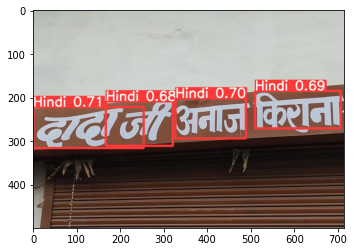

In [ ]:
img = plt.imread("/content/yolov5/runs/detect/exp6/12.jpg")
plt.imshow(img)
plt.show